# Standard Machine Learning methods

Here, we examine the performance of standard machine learning methods from the `scikit-learn` toolkit on our dataset of functional connectivities only.

The goal is to examine performance on these shallow methods to get a set of baseline results.

In [26]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Load data

In [5]:
DATA_FOLDER = '../data'
PICKLE_FOLDER = '../pickles'

In [6]:
with open(f'{PICKLE_FOLDER}/fc-pearson.pickle', 'rb') as f:
    fc_pearson = pickle.load(f)

In [7]:
with open(f'{PICKLE_FOLDER}/fc-spearman.pickle', 'rb') as f:
    fc_spearman = pickle.load(f)

In [8]:
with open(f'{PICKLE_FOLDER}/fc-partial-pearson.pickle', 'rb') as f:
    fc_partial_pearson = pickle.load(f)

In [9]:
total_samples, total_brain_regions, _ = fc_pearson.shape

print(f'Subjects: {total_samples}')
print(f'Brain regions: {total_brain_regions}')

Subjects: 190
Brain regions: 90


In [10]:
df_metadata = pd.read_csv(f'{DATA_FOLDER}/patients-cleaned.csv', index_col=0)

In [11]:
df_metadata.head(3)

,age,sex,target
0,24.750,1,0
1,27.667,1,0
2,34.167,1,0


## Split data

In [12]:
with open(f'{PICKLE_FOLDER}/test-indices.pickle', 'rb') as f:
    test_indices = pickle.load(f)

In [13]:
# Select dataset.
fc = fc_pearson.copy()

In [14]:
X_test = fc[test_indices]
y_test = df_metadata.iloc[test_indices]["target"].reset_index(drop=True)

In [15]:
train_indices = ~np.isin(np.arange(total_samples), test_indices)
X_train = fc[train_indices]
y_train = df_metadata.iloc[train_indices]["target"].reset_index(drop=True)

In [16]:
# Flatten FC matrices for ML models.
X_test = np.reshape(X_test, (-1, total_brain_regions * total_brain_regions))
X_train = np.reshape(X_train, (-1, total_brain_regions * total_brain_regions))

## Metrics

In [17]:
def confusion_matrix_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"Accuracy: {(tp+tn)/(fn+tp+tn+fp):.2f}")
    print(f"Recall: {tp}/{fn+tp} ({tp/(fn+tp):.2f})")
    print(f"Precision: {tp}/{tp+fp} ({tp/(tp+fp):.2f})")
    print()

## Training

In [18]:
# Cross validation using 7 folds: 140 = 120 + 20.
# Per `GridSearchCV` documentation `StratifiedKFold` is used to get balanced folds.
NUM_FOLDS = 7
grid_kwargs = {"cv": NUM_FOLDS, "n_jobs": -1}

In [19]:
def cross_validate(estimator, estimator_params, grid_kwargs=grid_kwargs):
    """
    Performs cross-validation using train dataset on estimator.
    Optionally takes grid search settings.
    """
    grid = GridSearchCV(estimator, estimator_params, **grid_kwargs)
    grid.fit(X_train, y_train)
    results = pd.DataFrame(grid.cv_results_)
    y_pred = grid.best_estimator_.predict(X_train)
    confusion_matrix_custom(y_train.values, y_pred)

    cv_params = ["params", "mean_test_score", "std_test_score"] + [f"split{i}_test_score" for i in range(NUM_FOLDS)]

    return results.sort_values(by=['rank_test_score'])[cv_params]

In [20]:
# Ensure we see the full `params` field.
pd.options.display.max_colwidth = 200

## ML Models
- KNN
- Naive Bayes
- Random Forest
- SVC
- Elastic Net based logistic regression

In [58]:
# Nearest neighbor.
knn = KNeighborsClassifier()
knn_params = {"n_neighbors": [1, 2, 3, 4, 5, 7, 10], "p": [1, 2], "weights": ("uniform", "distance")}
cross_validate(knn, knn_params)

Accuracy: 1.00
Recall: 75/75 (1.00)
Precision: 75/75 (1.00)



,params,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score
0,"{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}",0.714286,0.098974,0.80,0.85,0.65,0.70,0.55,0.80,0.65
1,"{'n_neighbors': 1, 'p': 1, 'weights': 'distance'}",0.714286,0.098974,0.80,0.85,0.65,0.70,0.55,0.80,0.65
5,"{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}",0.714286,0.098974,0.80,0.85,0.65,0.70,0.55,0.80,0.65
10,"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.714286,0.063888,0.80,0.80,0.70,0.65,0.65,0.75,0.65
11,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}",0.714286,0.063888,0.80,0.80,0.70,0.65,0.65,0.75,0.65
8,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.707143,0.097938,0.80,0.80,0.75,0.60,0.65,0.80,0.55
9,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}",0.707143,0.097938,0.80,0.80,0.75,0.60,0.65,0.80,0.55
2,"{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}",0.700000,0.088641,0.75,0.85,0.65,0.70,0.55,0.75,0.65
3,"{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}",0.700000,0.088641,0.75,0.85,0.65,0.70,0.55,0.75,0.65
19,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.700000,0.080178,0.80,0.75,0.65,0.75,0.55,0.65,0.75


In [59]:
# Naive Bayes.
gnb = GaussianNB()
gnb_params = {"var_smoothing": [1e-15, 1e-10, 1e-9, 1e-8, 1e-5, 1e-2, 1e-1]}
cross_validate(gnb, gnb_params)

Accuracy: 0.89
Recall: 68/75 (0.91)
Precision: 68/76 (0.89)



,params,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score
5,{'var_smoothing': 0.01},0.792857,0.082065,0.70,0.75,0.75,0.85,0.7,0.9,0.90
0,{'var_smoothing': 1e-15},0.785714,0.091473,0.65,0.75,0.75,0.85,0.7,0.9,0.90
1,{'var_smoothing': 1e-10},0.785714,0.091473,0.65,0.75,0.75,0.85,0.7,0.9,0.90
2,{'var_smoothing': 1e-09},0.785714,0.091473,0.65,0.75,0.75,0.85,0.7,0.9,0.90
3,{'var_smoothing': 1e-08},0.785714,0.091473,0.65,0.75,0.75,0.85,0.7,0.9,0.90
4,{'var_smoothing': 1e-05},0.785714,0.091473,0.65,0.75,0.75,0.85,0.7,0.9,0.90
6,{'var_smoothing': 0.1},0.750000,0.100000,0.65,0.65,0.70,0.90,0.7,0.9,0.75


In [63]:
# Random forest.
rf = RandomForestClassifier()
rf_params = {"n_estimators": [50, 100, 200, 500], "max_depth": [1,2,3,5, None], "criterion": ("entropy", "gini")}
cross_validate(rf, rf_params)

Accuracy: 1.00
Recall: 75/75 (1.00)
Precision: 75/75 (1.00)



,params,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score
28,"{'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}",0.814286,0.132865,0.60,0.65,0.85,0.80,1.00,0.90,0.90
36,"{'criterion': 'gini', 'max_depth': None, 'n_estimators': 50}",0.800000,0.122474,0.55,0.75,0.75,0.95,0.85,0.85,0.90
11,"{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 500}",0.792857,0.101519,0.60,0.80,0.80,0.85,0.70,0.90,0.90
18,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 200}",0.785714,0.130149,0.55,0.70,0.75,0.90,0.75,0.95,0.90
15,"{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 500}",0.778571,0.116058,0.55,0.75,0.80,0.85,0.70,0.90,0.90
27,"{'criterion': 'gini', 'max_depth': 2, 'n_estimators': 500}",0.778571,0.124949,0.55,0.70,0.75,0.85,0.75,0.90,0.95
7,"{'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 500}",0.778571,0.133248,0.50,0.75,0.80,0.80,0.75,0.95,0.90
39,"{'criterion': 'gini', 'max_depth': None, 'n_estimators': 500}",0.771429,0.148461,0.55,0.70,0.80,0.85,0.60,0.95,0.95
33,"{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}",0.771429,0.116058,0.65,0.60,0.80,0.85,0.70,0.85,0.95
19,"{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 500}",0.771429,0.116058,0.55,0.70,0.80,0.80,0.75,0.95,0.85


In [66]:
# SVC.
svc = SVC()
svc_params = {"C": [0.1, 1, 10, 100, 1000], "kernel": ("poly", "rbf", "sigmoid"), "degree": [1,2,3,4]}
cross_validate(svc, svc_params)

Accuracy: 1.00
Recall: 75/75 (1.00)
Precision: 75/75 (1.00)



,params,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score
51,"{'C': 1000, 'degree': 2, 'kernel': 'poly'}",0.857143,0.108327,0.75,0.95,0.75,0.95,0.70,0.95,0.95
18,"{'C': 1, 'degree': 3, 'kernel': 'poly'}",0.857143,0.104978,0.70,0.95,0.85,0.95,0.70,0.90,0.95
39,"{'C': 100, 'degree': 2, 'kernel': 'poly'}",0.857143,0.108327,0.75,0.95,0.75,0.95,0.70,0.95,0.95
27,"{'C': 10, 'degree': 2, 'kernel': 'poly'}",0.857143,0.108327,0.75,0.95,0.75,0.95,0.70,0.95,0.95
24,"{'C': 10, 'degree': 1, 'kernel': 'poly'}",0.857143,0.094221,0.75,0.90,0.75,0.95,0.75,0.95,0.95
48,"{'C': 1000, 'degree': 1, 'kernel': 'poly'}",0.857143,0.094221,0.75,0.90,0.75,0.95,0.75,0.95,0.95
36,"{'C': 100, 'degree': 1, 'kernel': 'poly'}",0.857143,0.094221,0.75,0.90,0.75,0.95,0.75,0.95,0.95
46,"{'C': 100, 'degree': 4, 'kernel': 'rbf'}",0.850000,0.122474,0.65,0.95,0.80,0.95,0.70,0.95,0.95
58,"{'C': 1000, 'degree': 4, 'kernel': 'rbf'}",0.850000,0.122474,0.65,0.95,0.80,0.95,0.70,0.95,0.95
25,"{'C': 10, 'degree': 1, 'kernel': 'rbf'}",0.850000,0.122474,0.65,0.95,0.80,0.95,0.70,0.95,0.95


In [46]:
# Elastic Net.
eln = SGDClassifier()
eln_params = {"loss": ["log", "modified_huber"], "alpha": [0.1, 0.01, 0.001], "penalty": ["elasticnet"], "l1_ratio": [0.15, 0.25, 0.5, 0.7], "max_iter": [1000, 10000, 20000]}
cross_validate(eln, eln_params)

Accuracy: 0.99
Recall: 73/75 (0.97)
Precision: 73/73 (1.00)



,params,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score
10,"{'alpha': 0.1, 'l1_ratio': 0.25, 'loss': 'modified_huber', 'max_iter': 10000, 'penalty': 'elasticnet'}",0.885714,0.069253,0.80,0.90,0.80,1.00,0.85,0.90,0.95
3,"{'alpha': 0.1, 'l1_ratio': 0.15, 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'elasticnet'}",0.857143,0.086307,0.75,0.85,0.80,0.95,0.75,0.95,0.95
41,"{'alpha': 0.01, 'l1_ratio': 0.5, 'loss': 'modified_huber', 'max_iter': 20000, 'penalty': 'elasticnet'}",0.850000,0.084515,0.70,0.90,0.85,0.90,0.75,0.95,0.90
55,"{'alpha': 0.001, 'l1_ratio': 0.25, 'loss': 'log', 'max_iter': 10000, 'penalty': 'elasticnet'}",0.842857,0.086307,0.75,0.90,0.80,0.90,0.70,0.95,0.90
56,"{'alpha': 0.001, 'l1_ratio': 0.25, 'loss': 'log', 'max_iter': 20000, 'penalty': 'elasticnet'}",0.842857,0.111575,0.75,0.95,0.70,0.95,0.70,0.90,0.95
...,...,...,...,...,...,...,...,...,...,...
18,"{'alpha': 0.1, 'l1_ratio': 0.7, 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet'}",0.535714,0.022588,0.50,0.50,0.55,0.55,0.55,0.55,0.55
14,"{'alpha': 0.1, 'l1_ratio': 0.5, 'loss': 'log', 'max_iter': 20000, 'penalty': 'elasticnet'}",0.535714,0.022588,0.50,0.50,0.55,0.55,0.55,0.55,0.55
13,"{'alpha': 0.1, 'l1_ratio': 0.5, 'loss': 'log', 'max_iter': 10000, 'penalty': 'elasticnet'}",0.535714,0.022588,0.50,0.50,0.55,0.55,0.55,0.55,0.55
12,"{'alpha': 0.1, 'l1_ratio': 0.5, 'loss': 'log', 'max_iter': 1000, 'penalty': 'elasticnet'}",0.535714,0.022588,0.50,0.50,0.55,0.55,0.55,0.55,0.55


## Observations

- 1. KNN

Mean test score is best at 3 neighbors (71 += 6 %). Single and 5 neighbors produce similar and slightly worse scores (70 += 8 %). Interestingly the score falls sharply for 2 neighbors to (61 += 10 %) and 4 neighbors (61 += 7 %). There are always weak and strong folds: 55 - 85 %, hence large std.

Hyperparamters `p` and `weigths` don't affect results in a significant way.


- 2. Naive Bayes

Independantly of the `var_smoothing` hyperparameter the perfomance is consistently (79 += 9 %). Again, a large variance is obsererved. Weak folds get 65 to 70 percent and strong ones up to 90 % accuracy.

- 3. Random Forest

Random forests achieve 80 % accuracy, but the variance is large 10 - 13 %. Some folds are classified hundred percent correctly. The effect of hyperparameters results in about 4 % diffence, which is only third of variance.

- 4. SVC

Low polynomial kernels perform the best. They are not particularly sensitive to choice of `C` and `degree=[1,2,3]`. The accuracy is (85 += 10 %). A clear pattern of easy and hard folds can be observed. Four folds get 95 % accuracy and three 70 - 75 % accuracy.

- 5. Elastic Net alá logistic regression

This classifier proved to be the best with accuracy (87 += 8 %). It adds two percent to mean and sheds two percent from std in comparison to SVC. The `hinge` loss for Elastic net is actually equivalent to linear SVC, while the `log` loss gives logistic regression. Generally, the folds are not strictly weak or strong. Ussually, we get a weak one, one or two middle ones and then strong ones.

## Explainability

### Random forest and gini impurance

In [32]:
rf = RandomForestClassifier(criterion='gini', max_depth=3, n_estimators=50) # Best RF from above.
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=50)

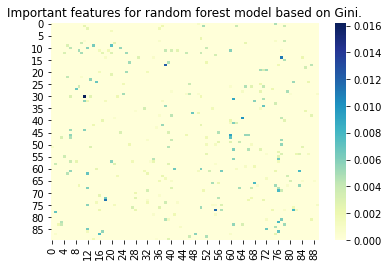

In [34]:
sns.heatmap(np.reshape(rf.feature_importances_, (total_brain_regions, total_brain_regions)), cmap="YlGnBu")
plt.title(f"Important features for random forest model based on Gini.")
plt.show()

#### Save the importance matrix for dataset creation.

In [38]:
gini_matrix = np.reshape(np.where(rf.feature_importances_ > 0, True, False), (total_brain_regions, total_brain_regions))

with open(f'{PICKLE_FOLDER}/gini-importance-matrix.pickle', 'wb') as f:
    pickle.dump(gini_matrix, f)

### Best model - SGD classifier - and its coefficients

In [48]:
# Best SGD from above with std < 10 %.
eln = SGDClassifier(alpha=0.01, l1_ratio=0.5, loss='log', max_iter=20000, penalty='elasticnet')
eln.fit(X_train, y_train)

SGDClassifier(alpha=0.01, l1_ratio=0.5, loss='log', max_iter=20000,
              penalty='elasticnet')

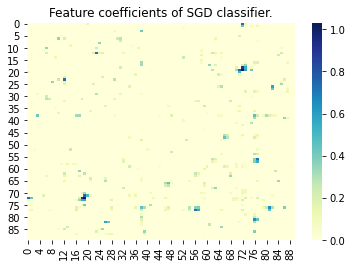

In [51]:
sns.heatmap(np.abs(np.reshape(eln.coef_, (total_brain_regions, total_brain_regions))), cmap="YlGnBu")
plt.title(f"Feature coefficients of SGD classifier.")
plt.show()

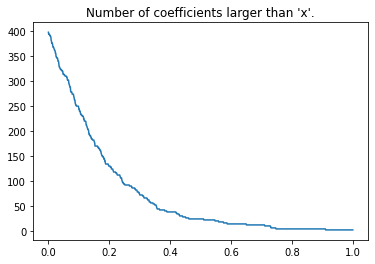

In [66]:
x = np.linspace(0, 1, 1000)
y = [np.sum(np.abs(eln.coef_) > i) for i in x]
plt.plot(x, y)
plt.title(f"Number of coefficients larger than 'x'.")
plt.show()

In [67]:
#### Save the coefficient matrix for dataset creation.
sgd_matrix = np.reshape(np.where(eln.coef_ > 0, True, False), (total_brain_regions, total_brain_regions))

with open(f'{PICKLE_FOLDER}/sgd-coefficients-matrix.pickle', 'wb') as f:
    pickle.dump(sgd_matrix, f)